In [1]:
import os
import re
import gc
import h5py
import torch
import string
import random
import numpy as np
import tensorflow as tf

from tqdm import tqdm
from nltk import tokenize
from sklearn import preprocessing

from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from transformers import BertTokenizer, BertForMaskedLM, BertModel
from tensorflow.keras import Model

In [2]:
IMAGE_SIZE = (224, 224)
NUM_CHANNELS = 3

In [3]:
mvsa_single_path = '../input/mvsa-data/mvsa-single-4316.hdf5'
mvsa_multiple_path = '../input/mvsa-data/mvsa-multiple-16387.hdf5'

In [4]:
def clean_text(txt):
#     nonEnglish_regex = re.compile('[^a-zA-Z0-9\\?\\!\\,\\.@#\\+\\-=\\*\'\"><&\\$%\\(\\)\\[\\]:;]+')
#     hashtag_pattern = re.compile('#[a-zA-Z0-9]+')
#     txt_hashtag = re.sub(hashtag_pattern, '', txt)
    at_pattern = re.compile('@[a-zA-Z0-9]+')
    http_pattern = re.compile("((http|ftp|https)://)(([a-zA-Z0-9\._-]+\.[a-zA-Z]{2,6})|([0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}))(:[0-9]{1,4})*(/[a-zA-Z0-9\&%_\./-~-]*)?")
    punc_pattern = re.compile('[%s]' % re.escape(string.punctuation))
    txt = re.sub(at_pattern, '<user>', txt)
    txt = re.sub(http_pattern, '<link>', txt)
    
    # as the data was crawled using Twitter API, it marked retweet data with RT <user> tag which has no meaning considering it in training
    if txt.startswith('RT <user>'):
        txt = ''.join(txt.split(':')[1:])    
    txt = txt.strip()
    
    return txt

In [5]:
def get_clean_texts(data):
    cleaned_data = []
    for line in data:
        text = clean_text(line)
        cleaned_data.append(text)
    return cleaned_data

In [6]:
def read_hdf5(path):
    read_file = h5py.File(path, 'r')
    
    feature_names = list(read_file.keys())
    loaded_data = []
    
    for name in feature_names:
        dataset = read_file[name][:]
        if dataset.dtype == np.dtype('object'):
            dataset = np.array([x.decode('UTF-8') for x in dataset])            
        loaded_data.append((name, dataset))

    return loaded_data

In [7]:
def load_mvsa_data(path, multiple=False):
    data = read_hdf5(path)
    for x in data:
        if x[0] == 'texts':
            texts = x[1]
        if x[0] == 'images':
            images = x[1]
        if x[0] == 'multimodal-labels':
            labels = x[1]
        if x[0] == 'text-labels':
            text_labels = x[1]
        if x[0] == 'image-labels':
            image_labels = x[1]
            
    if multiple == True:
        images_path = os.path.join(os.path.split(path)[0], os.path.split(path)[1].split('.')[0] + '-images.npz')
#         npzfile = np.load(images_path)
#         images = npzfile['arr_0']
        images = loadz(images_path)
        
    return texts, images, labels, text_labels, image_labels

def loadz(path):
    data = np.load(path)['arr_0']
    return data

# Load raw data

In [8]:
mvsa_single_texts, mvsa_single_images, \
mvsa_single_multimodal_labels, mvsa_single_text_labels, \
mvsa_single_image_labels = load_mvsa_data(mvsa_single_path)
num_mvsa_single = len(mvsa_single_texts)

mvsa_multiple_texts, mvsa_multiple_images, \
mvsa_multiple_multimodal_labels, mvsa_multiple_text_labels, \
mvsa_multiple_image_labels = load_mvsa_data(mvsa_multiple_path, multiple=True)
num_mvsa_multiple = len(mvsa_multiple_texts)

-----Sample-----
Text label: neutral
Image label: neutral
Multimodal label: positive
Text: @raespoon ""The most important thing as a #transgender is to have humour"" @Thinklandia #yyj #yyjarts #LGBT #speakers
Image:


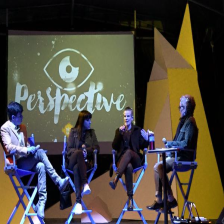

In [9]:
SAMPLE = random.choice(range(num_mvsa_multiple))
print('-----Sample-----')
print('Text label:', mvsa_multiple_text_labels[SAMPLE])
print('Image label:', mvsa_multiple_image_labels[SAMPLE])
print('Multimodal label:', mvsa_multiple_multimodal_labels[SAMPLE])
print('Text:', mvsa_multiple_texts[SAMPLE])
print('Image:')
tf.keras.utils.array_to_img(mvsa_multiple_images[SAMPLE][:, :, ::-1])

# Preprocess text

In [10]:
mvsa_single_texts = get_clean_texts(mvsa_single_texts)
mvsa_multiple_texts = get_clean_texts(mvsa_multiple_texts)

# Bert

In [11]:
# MAX_LENGTH = 280 # as in twitter word limit

In [12]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')# bert_model = BertForMaskedLM.from_pretrained('bert-base-uncased', return_dict = True)
bert_model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)
# bert_model.eval() # (evaluation mode is default) put model in evaluation model, turn of regularization in training

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [13]:
def bert_embed_sentence(text, tokenizer=bert_tokenizer, model=bert_model):
#     inputs = tokenizer(text, return_tensors='pt', max_length=MAX_LENGTH, padding='max_length')
    inputs = tokenizer(text, return_tensors='pt')
    
    with torch.no_grad():
        outputs = model(**inputs, )
        last_hidden_states = outputs.hidden_states[-1][0]
        cls_token = last_hidden_states[0]
        bert_embeddings = torch.squeeze(cls_token, dim=0).numpy()
    
    return bert_embeddings

In [14]:
def bert_embed_data(data):
    embedded_data = np.array([])
    
    for line in tqdm(data):
        bert_embeddings = bert_embed_sentence(line)
        if embedded_data.shape[0] == 0:
            embedded_data = np.array([bert_embeddings])#np.empty((0, embedded_line.shape[0]), 'float32')
        else:
            embedded_data = np.concatenate((embedded_data, [bert_embeddings]))
            
    return embedded_data

In [15]:
print('MVSA-Single: Extracting bert features of texts')
mvsa_single_bert_base = bert_embed_data(mvsa_single_texts)
print('BERT-base CLS token in last hidden layer dimension:', mvsa_single_bert_base.shape[1])
print('MVSA-Single with BERT-base CLS token in last hidden layer:', mvsa_single_bert_base.shape)

# save and load check
np.savez('./mvsa-single-bert-base', mvsa_single_bert_base)
x = loadz('./mvsa-single-bert-base.npz')
print((x == mvsa_single_bert_base).all())

MVSA-Single: Extracting bert features of texts


100%|██████████| 4316/4316 [05:20<00:00, 13.45it/s]


BERT-base CLS token in last hidden layer dimension: 768
MVSA-Single with BERT-base CLS token in last hidden layer: (4316, 768)
True


In [16]:
print('MVSA-Multiple: Extracting bert features of texts')
mvsa_multiple_bert_base = bert_embed_data(mvsa_multiple_texts)
print('BERT-base CLS token in last hidden layer dimenion:', mvsa_multiple_bert_base.shape[1])
print('MVSA-Multiple with BERT-base CLS token in last hidden layer:', mvsa_multiple_bert_base.shape)

# save and load check
np.savez('./mvsa-multiple-bert-base', mvsa_multiple_bert_base)
x = loadz('./mvsa-multiple-bert-base.npz')
print((x == mvsa_multiple_bert_base).all())

MVSA-Multiple: Extracting bert features of texts


100%|██████████| 16387/16387 [22:16<00:00, 12.26it/s]


BERT-base CLS token in last hidden layer dimenion: 768
MVSA-Multiple with BERT-base CLS token in last hidden layer: (16387, 768)
True
